## Problem 1 (15 points)
1-Factor Affine model:

Read Chapter 3 of the Fisher & Gilles paper.

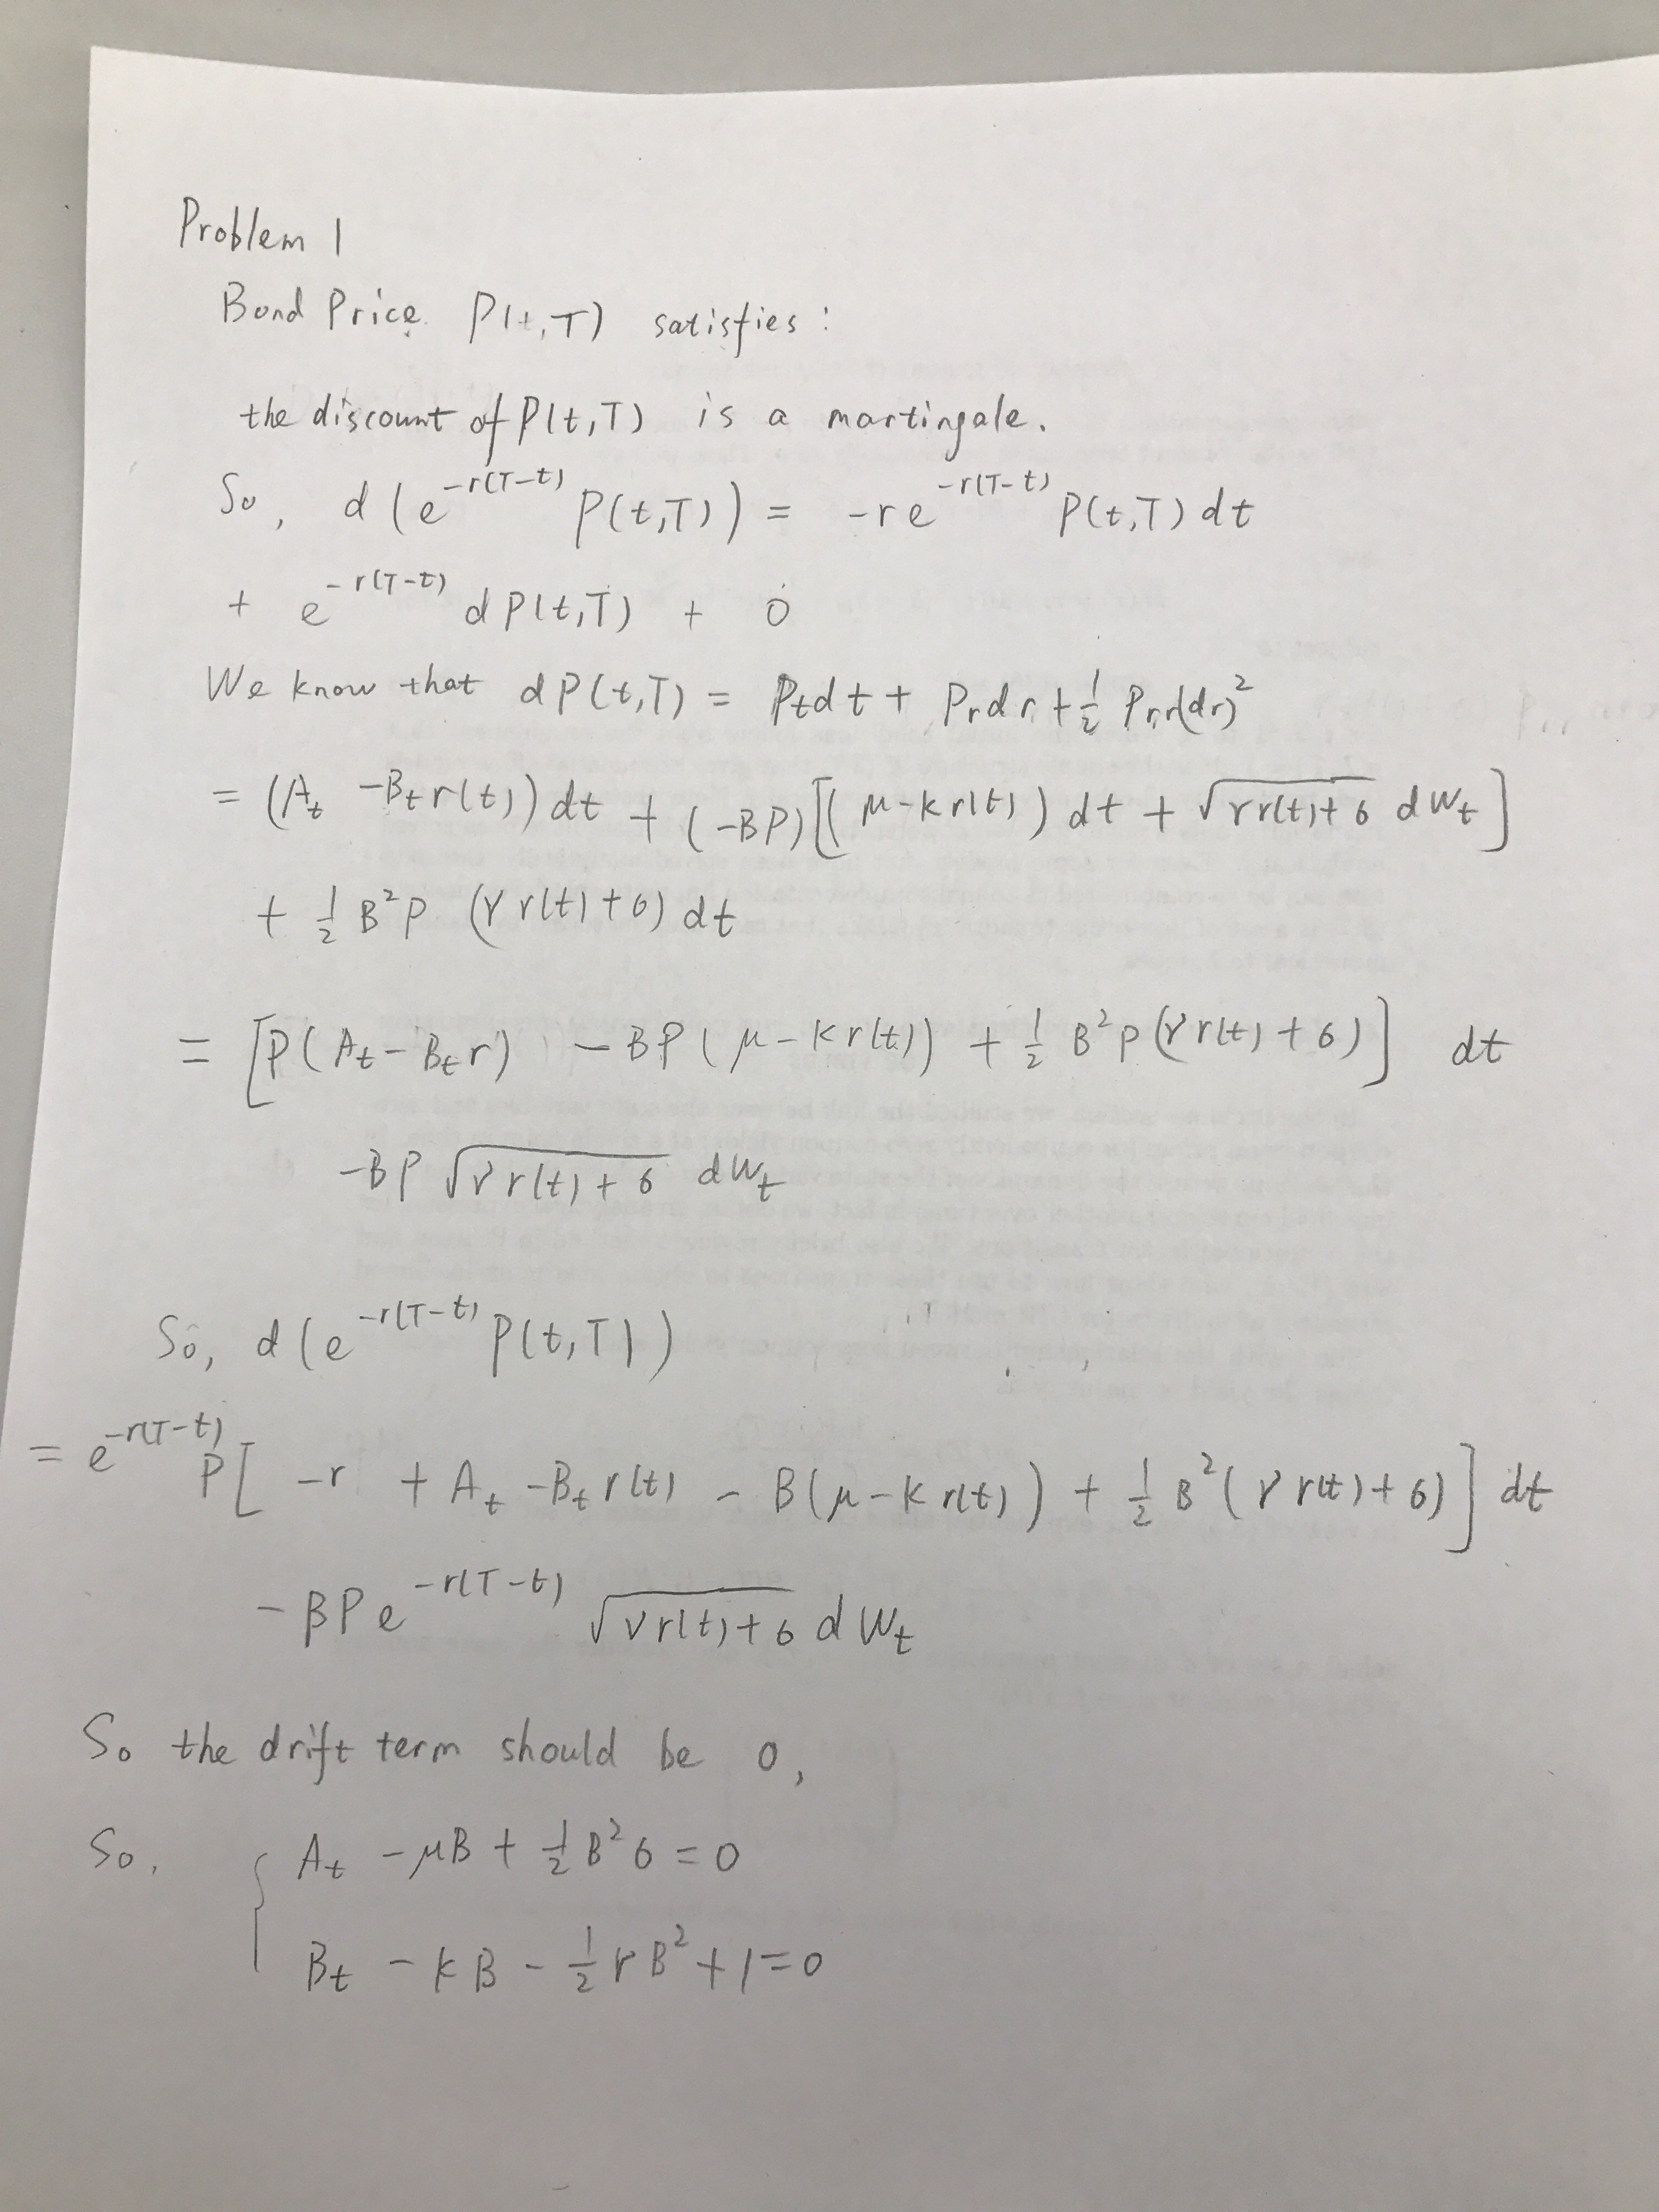

In [99]:
from IPython.display import Image
Image("HW3Q1.jpg")

## Problem 2 (45 ponts):
Dataset: Settle prices of rst 8 (most liquid) rolling Eurodollar futures you got from Quandl.

Sample1: Jan-2004 through Dec-2006

Weighted Spread (WSPR): fi- w*fj; fi is a futures rate of the i-th rolling Eurodollar.
### 1. Using Sample1 construct all possible cointegrated WSPR using CCA and/or level regression.
How many possible combinations will you have?

In [1]:
import quandl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime

token = "bPGmPJ9_Htme3REKTKtT"
n = range(1,10)
nms = ["CHRIS/CME_ED"+str(i) for i in n]
dfs = [quandl.get(nm, authtoken=token) for nm in nms] #an array of pandas data frames
data = [data_set.Settle for data_set in dfs] #pull column Settle
data = pd.concat(data,axis=1) #combine cols together
data.columns = ["Settle_ED"+str(i) for i in n]

In [2]:
data.index = pd.to_datetime(data.index)
#data.set_index('Date', inplace=True)
data_set = data.loc['2004-01':,:]
data_set = 100 - data_set
data_set.head()

,Settle_ED1,Settle_ED2,Settle_ED3,Settle_ED4,Settle_ED5,Settle_ED6,Settle_ED7,Settle_ED8,Settle_ED9
Date,,,,,,,,,
2004-01-02,1.240,1.495,1.875,2.320,2.740,3.145,3.485,3.790,4.020
2004-01-05,1.235,1.475,1.855,2.305,2.740,3.145,3.490,3.790,4.030
2004-01-06,1.215,1.420,1.735,2.140,2.565,2.980,3.330,3.630,3.875
2004-01-07,1.210,1.415,1.735,2.135,2.555,2.960,3.300,3.590,3.840
2004-01-08,1.210,1.415,1.735,2.135,2.550,2.960,3.300,3.595,3.845


### Constant Maturity

In [224]:
imm = pd.read_csv('IMM.csv')
imm = imm.iloc[:,:10]
for col in imm.columns:
    imm[col] = pd.to_datetime(imm[col]) # convert string dates to datetime format
imm.set_index('0', inplace=True)
imm.columns = data_set.columns 
imm.head()

,Settle_ED1,Settle_ED2,Settle_ED3,Settle_ED4,Settle_ED5,Settle_ED6,Settle_ED7,Settle_ED8,Settle_ED9
0,,,,,,,,,
2004-01-02,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21,2006-03-15
2004-01-05,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21,2006-03-15
2004-01-06,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21,2006-03-15
2004-01-07,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21,2006-03-15
2004-01-08,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21,2006-03-15


In [225]:
assert imm.shape == data_set.shape, 'Warning: Two csv files have different dimensions!'

AssertionError: Warning: Two csv files have different dimensions!

In [226]:
# calculate actual/constant time to maturity, interpolated yields
actual = pd.DataFrame(columns = imm.columns, index = imm.index) # actual time to maturity
constant = actual  # constant time to maturity
yields = actual # linearly interpolated yields

# get the actual
for col in imm.columns:
    actual[col] = imm[col] - imm.index
actual = actual.applymap(lambda x: x.days)
actual.head()

,Settle_ED1,Settle_ED2,Settle_ED3,Settle_ED4,Settle_ED5,Settle_ED6,Settle_ED7,Settle_ED8,Settle_ED9
0,,,,,,,,,
2004-01-02,75,166,257,348,439,530,628,719,803
2004-01-05,72,163,254,345,436,527,625,716,800
2004-01-06,71,162,253,344,435,526,624,715,799
2004-01-07,70,161,252,343,434,525,623,714,798
2004-01-08,69,160,251,342,433,524,622,713,797


In [227]:
# get the constant
for i in range(constant.shape[0]-1): #row number
    for j in range(constant.shape[1]): #col number: 0,1,...,7
        y = constant.index[i].year
        m = constant.index[i].month
        d = constant.index[i].day
        y_add = (m+3*(j+1))/12
        m_new = (m+3*(j+1))%12
        if m_new == 0:
            y_add = y_add -1
            m_new = 12
        y_add = int(y_add // 1) # get the int before decimal
        try: 
            constant.iloc[i, j] =datetime.datetime(y+y_add, m_new, d) - constant.index[i]
        except ValueError:
            try:
                constant.iloc[i, j] = datetime.datetime(y+y_add, m_new, d-1) - constant.index[i]
            except ValueError:
                try:
                    constant.iloc[i, j] = datetime.datetime(y+y_add, m_new, d-2) - constant.index[i]
                except ValueError:
                    try:
                        constant.iloc[i, j] = datetime.datetime(y+y_add, m_new, d-3) - constant.index[i]
                    except ValueError:
                        constant.iloc[i, j] = datetime.datetime(y+y_add, m_new, d-4) - constant.index[i]  #2/27/2004
constant = constant.applymap(lambda x: x.days)
constant.head()

,Settle_ED1,Settle_ED2,Settle_ED3,Settle_ED4,Settle_ED5,Settle_ED6,Settle_ED7,Settle_ED8,Settle_ED9
0,,,,,,,,,
2004-01-02,91,182,274,366,456,547,639,731,821
2004-01-05,91,182,274,366,456,547,639,731,821
2004-01-06,91,182,274,366,456,547,639,731,821
2004-01-07,91,182,274,366,456,547,639,731,821
2004-01-08,91,182,274,366,456,547,639,731,821


In [228]:
yields = pd.DataFrame(columns = imm.columns, index = imm.index)
for i in range(yields.shape[0]):
    for j in range(yields.shape[1]-1): # perform linear interpolation
        yields.iloc[i,j] = np.interp(constant.iloc[i,j], actual.iloc[i,:], data_set.iloc[i,:])

In [229]:
# display actual/constant time to maturity & interpolated yields
print ('actual time to maturity: \n', actual.head(), '\n')
print ('constant time to maturity: \n', constant.head(), '\n')
print ('interpolated: \n', yields.head(), '\n')
yields.to_csv('Constant Maturity Eurodollar Futures.csv') 

actual time to maturity: 
             Settle_ED1  Settle_ED2  Settle_ED3  Settle_ED4  Settle_ED5  \
0                                                                        
2004-01-02          75         166         257         348         439   
2004-01-05          72         163         254         345         436   
2004-01-06          71         162         253         344         435   
2004-01-07          70         161         252         343         434   
2004-01-08          69         160         251         342         433   

            Settle_ED6  Settle_ED7  Settle_ED8  Settle_ED9  
0                                                           
2004-01-02         530         628         719         803  
2004-01-05         527         625         716         800  
2004-01-06         526         624         715         799  
2004-01-07         525         623         714         798  
2004-01-08         524         622         713         797   

constant time to maturity

In [286]:
df = pd.read_csv('Constant Maturity Eurodollar Futures.csv', index_col = 0, parse_dates = True)
df.index.name = 'Date'
del df[df.columns[8]]
df = df.dropna()
insample = df['1/1/2004':'12/31/2006']
outofsample = df['1/1/2007':'6/30/2007']
print(insample.head(),outofsample.head())

            Settle_ED1  Settle_ED2  Settle_ED3  Settle_ED4  Settle_ED5  \
Date                                                                     
2004-01-02    1.284835    1.561813    1.958132    2.403077    2.815659   
2004-01-05    1.285110    1.554341    1.953901    2.405385    2.829011   
2004-01-06    1.260055    1.489231    1.828462    2.242747    2.660769   
2004-01-07    1.257308    1.488846    1.831703    2.241154    2.652912   
2004-01-08    1.259560    1.492363    1.836099    2.244451    2.653626   

            Settle_ED6  Settle_ED7  Settle_ED8  
Date                                            
2004-01-02    3.203980    3.521868    3.822857  
2004-01-05    3.215408    3.536154    3.832857  
2004-01-06    3.055000    3.379451    3.676667  
2004-01-07    3.036327    3.350989    3.640595  
2004-01-08    3.039796    3.355110    3.648571               Settle_ED1  Settle_ED2  Settle_ED3  Settle_ED4  Settle_ED5  \
Date                                                            

### Box_Tiao function

In [287]:
# using Box_Tiao CCA
def Box_Tiao(i,j, datainfunction):
    df_B = datainfunction.loc[:,["Settle_ED"+str(i),"Settle_ED"+str(j)]]
    mu = df_B.mean()
    ##remove mean, get stationary series
    df_B = df_B - mu 
    data_set1 = df_B.iloc[:-1,:]
    data_set2 = df_B.iloc[1:,:]
    #or use formula(6) in mean revert paper: phiT = np.dot(np.dot(np.linalg.inv(np.dot(data_set1.T,data_set1)),data_set1.T),data_set2)
    phiT = np.linalg.lstsq(data_set1, data_set2)[0] # least-squares solution to a linear matrix equation data_set2 = data_set1*phiT
    covz = data_set1.cov()
    ##predictible measure Q
    #Q = np.dot( np.dot( np.dot(np.linalg.inv(covz), phiT.T), covz), phiT)
    Q = np.dot(np.linalg.inv(covz), np.dot(phiT,np.dot(covz,phiT.T)))
    val, vec = np.linalg.eig(Q)
    eigi_pairs = [(val[m], vec[:,m]) for m in range(len(val))]    
    eigi_pairs.sort(key=lambda x: x[0],reverse=False) #sort the eigenvalue from tuples from low to high
    
    ##find the eigenvecotr to the least eigenvalue as weights
    weight = eigi_pairs[0][1]
    w = - weight[1]/weight[0]
    #rowlist.append([i, j, eigi_pairs[0][0], w])######not using {}
    return w

### stationary test

In [295]:
#'statsmodels' to perform ADF test and OLS regression
import statsmodels.tsa.stattools as tsa 
import statsmodels.api as sm 

# define a function: stationary test for each portfolio
def stationary_test(data):
    # compute ADF test statistic
    adf_ = tsa.adfuller(data, maxlag=1)
    #print('adf', adf_[0])
    print('p-value', adf_[1])
    return adf_[1]

### in sample 2004-01~2006-12


In [301]:
n = range(1,9)
rowlist = []
pval_list = []#p value
count = 0
for i in n:
    for j in range(i+1,9):
        wij = Box_Tiao(i,j,insample)
        print(wij)
        dff = insample["Settle_ED"+str(i)] - wij* insample["Settle_ED"+str(j)]
        p_val = stationary_test(dff)
        pval_list.append(p_val)
        count +=1
        if p_val <= 0.1:
            print("the combination of ", i, " and ", j, ": stationary")
print("\npossible combinations: ", count)

#print(rowlist)
#df_w = pd.DataFrame(rowlist, columns = ['i', 'j', 'eigi', "w"]) 
#print(df_w)
#print("\npossible combinations: ", len(df_w))

0.990027102617
p-value 0.616105494464
1.44549513096
p-value 0.10947146018
1.83643030396
p-value 0.116198953708
2.35174882413
p-value 0.111257086185
3.06335679306
p-value 0.122773391377
4.0579849645
p-value 0.139851683397
5.47136950201
p-value 0.149915949002
1.38493681749
p-value 0.318485061541
1.65290908232
p-value 0.171454587897
2.08093897038
p-value 0.132948955436
2.67211993494
p-value 0.134129097701
3.48536337372
p-value 0.146436019915
4.64099427126
p-value 0.153499158572
1.67013761484
p-value 0.419855364427
1.8597030246
p-value 0.222158816266
2.26925482018
p-value 0.161593202218
2.86787642838
p-value 0.155475611094
3.7386219734
p-value 0.155815005294
2.12490417271
p-value 0.449535404342
1.98058351048
p-value 0.25732322341
2.32262629238
p-value 0.183058042812
2.93354461956
p-value 0.165654752293
2.04061763494
p-value 0.41643173222
1.89508411187
p-value 0.233606758439
2.28334327405
p-value 0.178937457895
1.6917271806
p-value 0.334755306637
1.81215882291
p-value 0.197102195587
1.76040

### best 5

In [298]:
vals = np.array(pval_list)
sort_index = np.argsort(vals)
count = 0
print("the best 5:")
for i in n:
    for j in range(i+1,9):
        count = count+1
        if count in sort_index[:5]:
            print("the combination of ",i," and ", j)

the best 5:
the combination of  1  and  2
the combination of  1  and  3
the combination of  1  and  4
the combination of  1  and  5
the combination of  2  and  4


### out of sample: 2007-01~2007-06

In [302]:
rowlist = []
pval_list = []#p value
for i in n:
    for j in range(i+1,9):
        wij = Box_Tiao(i,j,outofsample)
        dff = outofsample["Settle_ED"+str(i)] - wij* outofsample["Settle_ED"+str(j)]
        p_val = stationary_test(dff)
        pval_list.append(p_val)
        if p_val <= 0.1:
            print("the combination of ", i, " and ", j, ": stationary")
        

p-value 0.257176104563
p-value 0.146916329187
p-value 0.195077918158
p-value 0.229314254326
p-value 0.265581799367
p-value 0.285160366496
p-value 0.300654831991
p-value 0.21223148748
p-value 0.186252286361
p-value 0.184328562835
p-value 0.197465664674
p-value 0.208566953179
p-value 0.218995885199
p-value 0.38255150328
p-value 0.245251711474
p-value 0.232487628807
p-value 0.233758400613
p-value 0.246076702761
p-value 0.503565486445
p-value 0.388657535762
p-value 0.32788184525
p-value 0.330318925117
p-value 0.679823540053
p-value 0.531919885549
p-value 0.460684103278
p-value 0.697164379306
p-value 0.564065505584
p-value 0.752603713009


In [300]:
vals = np.array(pval_list)
sort_index = np.argsort(vals)
count = 0
print("the best 5:")
for i in n:
    for j in range(i+1,9):
        count = count+1
        if count in sort_index[:5]:
            print("the combination of ",i," and ", j)

the best 5:
the combination of  1  and  2
the combination of  1  and  3
the combination of  2  and  3
the combination of  2  and  4
the combination of  2  and  5


In [292]:
#rowlist = []
#for i in n:
#    for j in range(i+1,9):
#            Box_Tiao(i,j, outofsample)
#df_wout = pd.DataFrame(rowlist, columns = ['i', 'j', 'eigi', "w"]) 
#print(df_wout)

### Comparisions between in sample and out-sample results.

The best 5 portfolios are different.

I choose the 10% pvalue as the rejection starndard. There are no stationary portfolios in sample and out of sample. But the p value in sample is relatively lower than out of sample. I do not know why there are no stationary portfolios in sample and out of sample.

When I deal with the rolling data(without constant maturity), there are a stationary portfolio in sample and no stationary out of sample. The results are wield.